## Liver Segmentation Using Monai and PyTorch

YouTube:   https://www.youtube.com/watch?v=M3ZWfamWrBM

Code:      https://github.com/amine0110/Liver-Segmentation-Using-Monai-and-PyTorch

Documents: https://docs.monai.io/en/stable/index.html

Dataset:   https://www.synapse.org/#!Synapse:syn25649159/wiki/617548

In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# gData = '/gdrive/MyDrive/Data'

gData = '/home/achilles/Workspace/Data/'

In [3]:
import os
from glob import glob
import numpy as np


import torch
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm

In [4]:
# !pip install monai

In [5]:
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    NormalizeIntensityd,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import first, set_determinism
from monai.inferers import sliding_window_inference

In [6]:
data_dir  = os.path.join(gData, 'feta_2.1')
model_dir = os.path.join(gData, 'feta_2.1', 'results')

In [7]:
set_determinism(seed=0)

path_volumes = sorted(glob(data_dir + '/sub-*/anat/*_T2w.nii.gz'))
path_segmentation = sorted(glob(data_dir + '/sub-*/anat/*_dseg.nii.gz'))

path_train_volumes = path_volumes[:60]
path_train_segmentation = path_segmentation[:60]

path_valid_volumes = path_volumes[60:70]
path_valid_segmentation = path_segmentation[60:70]

path_test_volumes = path_volumes[70:]
path_test_segmentation = path_segmentation[70:]

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
valid_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_valid_volumes, path_valid_segmentation)]
test_files  = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes,  path_test_segmentation)]

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        # Spacingd(keys=["vol", "seg"], pixdim=(2, 2, 2), mode=("bilinear", "nearest")),
        # Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        # ScaleIntensityRanged(keys=["vol"], a_min=100, a_max=1000, b_min=0.0, b_max=1.0, clip=True), 
        NormalizeIntensityd(keys=["vol"], nonzero=True, channel_wise=True),
        # CropForegroundd(keys=["vol", "seg"], source_key="vol"),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,128]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

valid_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        # Spacingd(keys=["vol", "seg"], pixdim=(2, 2, 2), mode=("bilinear", "nearest")),
        # Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        # ScaleIntensityRanged(keys=["vol"], a_min=100, a_max=1000,b_min=0.0, b_max=1.0, clip=True), 
        NormalizeIntensityd(keys=["vol"], nonzero=True, channel_wise=True),
        # CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,128]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=1)

valid_ds = CacheDataset(data=valid_files, transform=valid_transforms, cache_rate=1.0)
valid_loader = DataLoader(valid_ds, batch_size=1)

Loading dataset: 100%|██████████████████████████| 10/10 [00:04<00:00,  2.10it/s]


In [10]:
train_ds.__getitem__(0)['vol'].shape

torch.Size([1, 128, 128, 128])

In [11]:
valid_ds.__getitem__(0)['seg'].shape

torch.Size([1, 128, 128, 128])

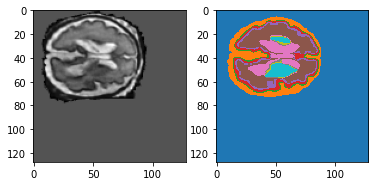

In [12]:
item = train_ds.__getitem__(0)
plt.figure("check", (6, 18))
plt.subplot(1, 2, 1)
plt.imshow(item['vol'][0, :, :, 50], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(item['seg'][0, :, :, 50], cmap="tab10")
plt.show()

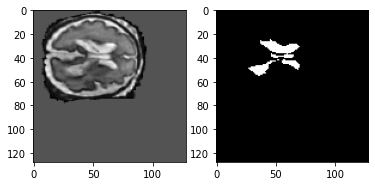

In [13]:
batch_data = first(train_loader)
volume = batch_data["vol"]
label = batch_data["seg"]
label = label == 4
plt.figure("check", (6, 18))
plt.subplot(1, 2, 1)
plt.imshow(volume[0, 0, :, :, 50], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(label[0, 0, :, :, 50], cmap="gray")
plt.show()

In [14]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [15]:
# model.load_state_dict(torch.load(
#     os.path.join(model_dir, "best_metric_model.pth")))

In [16]:
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5, amsgrad=True)

In [16]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [17]:
best_metric = -1
best_metric_epoch = -1
save_loss_train = []
save_loss_valid = []
save_metric_train = []
save_metric_valid = []

In [18]:
max_epochs = 50
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    train_epoch_loss = 0
    train_step = 0
    epoch_metric_train = 0
    # pbar = tqdm(total=len(train_loader))
    for batch_data in train_loader:
        train_step += 1
        
        volume = batch_data["vol"]
        label = batch_data["seg"]
        label = label == 4
        volume, label = (volume.to(device), label.to(device))

        optimizer.zero_grad()
        outputs = model(volume)
        
        train_loss = loss_function(outputs, label)
            
        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        # print(
        #     f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
        #     f"Train_loss: {train_loss.item():.4f}")

        train_metric = dice_metric(outputs, label)
        epoch_metric_train += train_metric
        # print(f'Train_dice: {train_metric:.4f}')
        print('=', end='')
        # pbar.update(1)
    # pbar.close()

    # print('-'*20)

    train_epoch_loss /= train_step
    # print(f'Epoch_loss: {train_epoch_loss:.4f}')
    save_loss_train.append(train_epoch_loss)
    np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

    epoch_metric_train /= train_step
    print(f' Epoch_metric: {epoch_metric_train:.4f}')

    save_metric_train.append(epoch_metric_train)
    np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

    if (epoch + 1) % 1 == 0:

        model.eval()
        with torch.no_grad():
            valid_epoch_loss = 0
            valid_metric = 0
            epoch_metric_valid = 0
            valid_step = 0

            for valid_data in valid_loader:

                valid_step += 1

                valid_volume = valid_data["vol"]
                valid_label = valid_data["seg"]
                valid_label = valid_label == 4
                valid_volume, valid_label = (valid_volume.to(device), valid_label.to(device),)

                valid_outputs = model(valid_volume)

                valid_loss = loss_function(valid_outputs, valid_label)
                valid_epoch_loss += valid_loss.item()
                valid_metric = dice_metric(valid_outputs, valid_label)
                epoch_metric_valid += valid_metric
         
            valid_epoch_loss /= valid_step
            # print(f'valid_loss_epoch: {valid_epoch_loss:.4f}')
            save_loss_valid.append(valid_epoch_loss)
            np.save(os.path.join(model_dir, 'loss_valid.npy'), save_loss_valid)

            epoch_metric_valid /= valid_step
            # print(f'valid_dice_epoch: {epoch_metric_valid:.4f}')
            save_metric_valid.append(epoch_metric_valid)
            np.save(os.path.join(model_dir, 'metric_valid.npy'), save_metric_valid)

            if epoch_metric_valid > best_metric:
                best_metric = epoch_metric_valid
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    model_dir, "best_metric_model.pth"))

            print(
                # f"current epoch: {epoch + 1} current mean dice: {epoch_metric_valid:.4f}"
                # f"\nbest mean dice: {best_metric:.4f} "
                # f"at epoch: {best_metric_epoch}"
                f"current mean dice: {epoch_metric_valid:.4f} "
                f"best mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/50
============================================================ Epoch_metric: 0.4739
current mean dice: 0.5013 best mean dice: 0.5013 at epoch: 1
----------
epoch 2/50
============================================================ Epoch_metric: 0.5137
current mean dice: 0.5282 best mean dice: 0.5282 at epoch: 2
----------
epoch 3/50
============================================================ Epoch_metric: 0.5565
current mean dice: 0.5855 best mean dice: 0.5855 at epoch: 3
----------
epoch 4/50
============================================================ Epoch_metric: 0.6863
current mean dice: 0.6476 best mean dice: 0.6476 at epoch: 4
----------
epoch 5/50
============================================================ Epoch_metric: 0.8134
current mean dice: 0.7532 best mean dice: 0.7532 at epoch: 5
----------
epoch 6/50
============================================================ Epoch_metric: 0.8220
current mean dice: 0.6171 best mean dice: 0.7532 at epoch: 5
----------

In [19]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
valid_loss = np.load(os.path.join(model_dir, 'loss_valid.npy'))
valid_metric = np.load(os.path.join(model_dir, 'metric_valid.npy'))

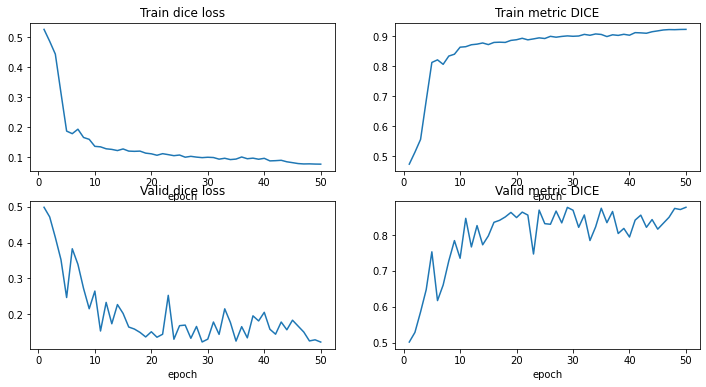

In [20]:
plt.figure("Results", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Valid dice loss")
x = [i + 1 for i in range(len(valid_loss))]
y = valid_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Valid metric DICE")
x = [i + 1 for i in range(len(valid_metric))]
y = valid_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [17]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        # Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        # Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        # ScaleIntensityRanged(keys=["vol"], a_min=100, a_max=1000,b_min=0.0, b_max=1.0, clip=True), 
        NormalizeIntensityd(keys=["vol"], nonzero=True, channel_wise=True),
        # CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,128]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [18]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_list = list(test_loader)

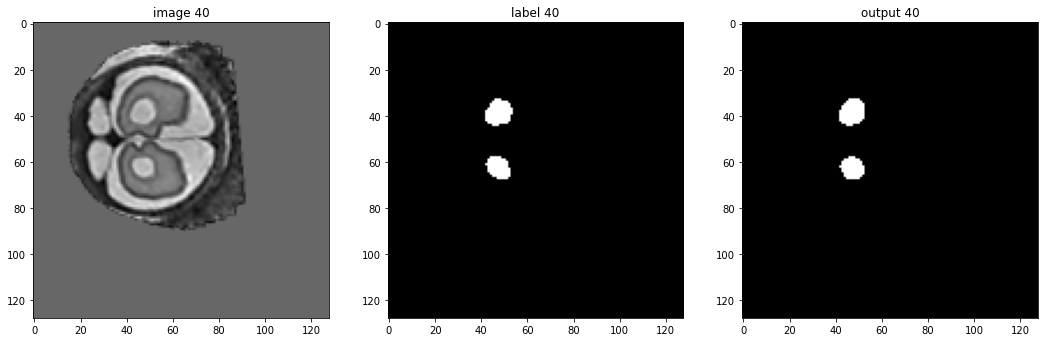

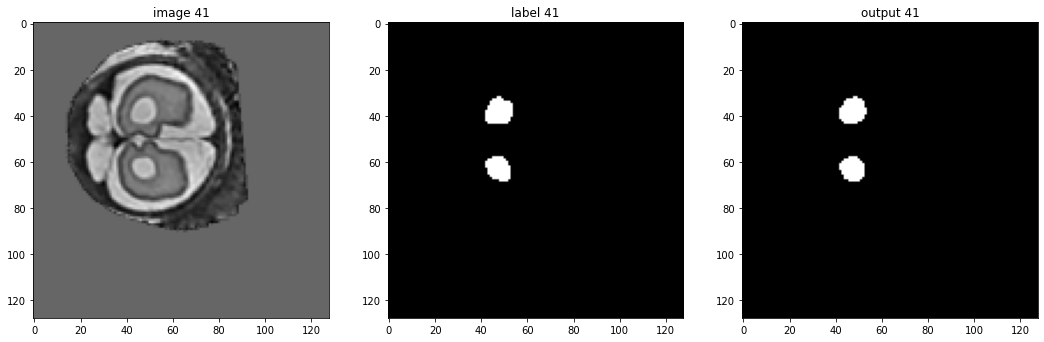

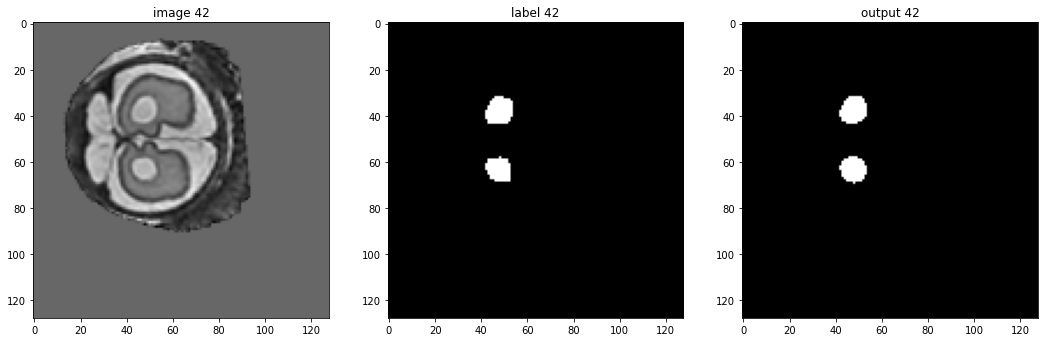

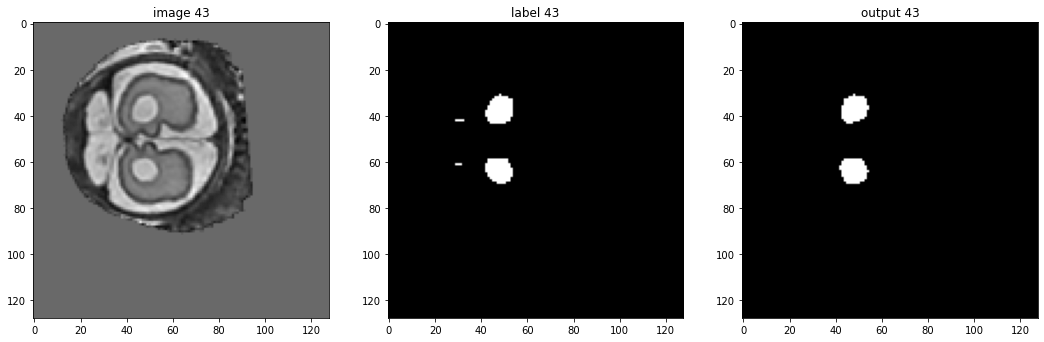

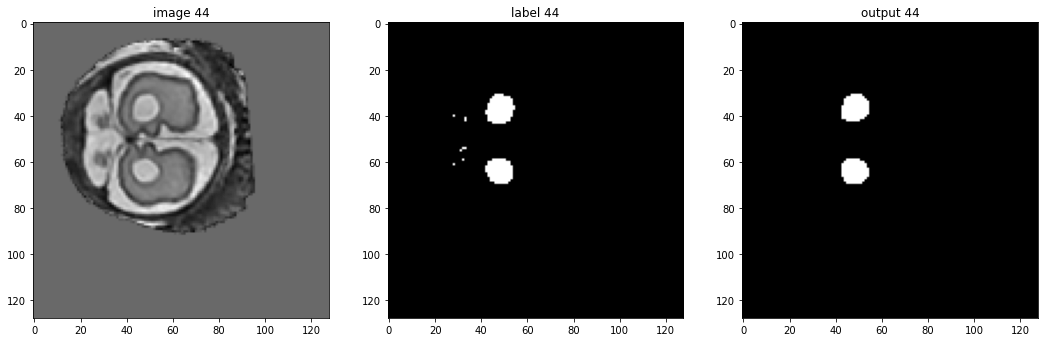

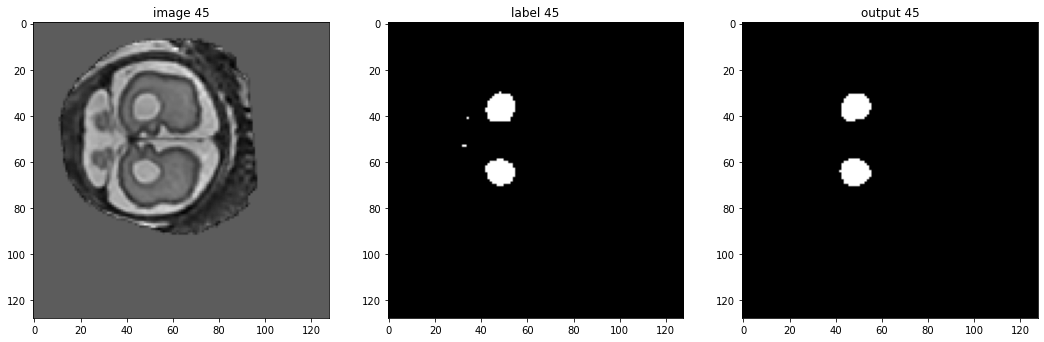

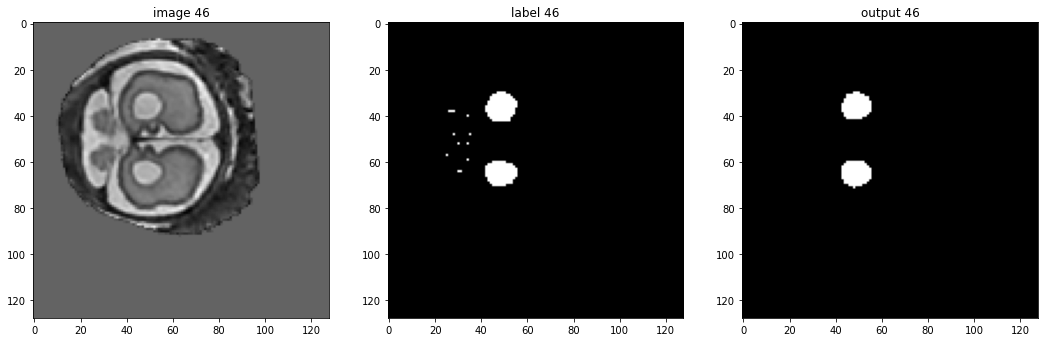

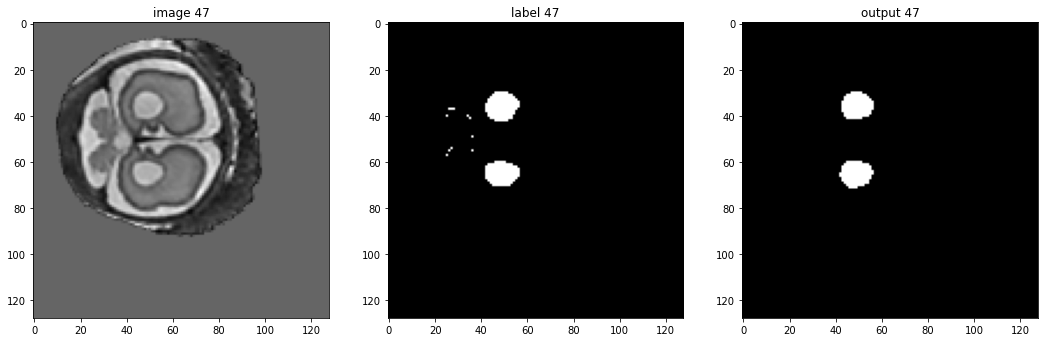

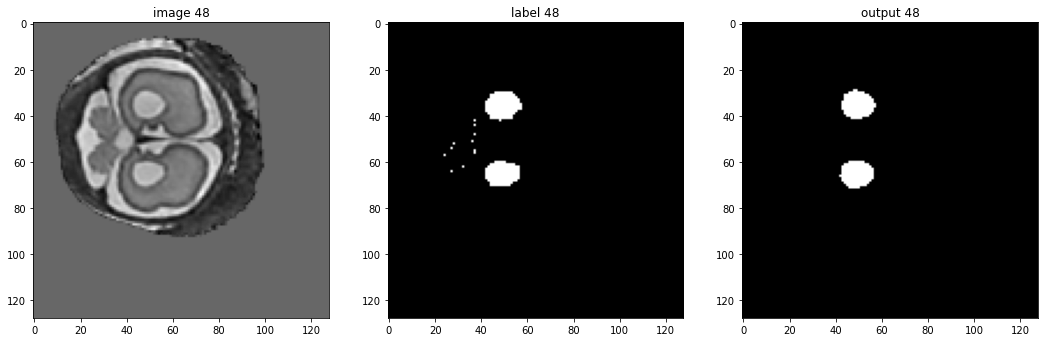

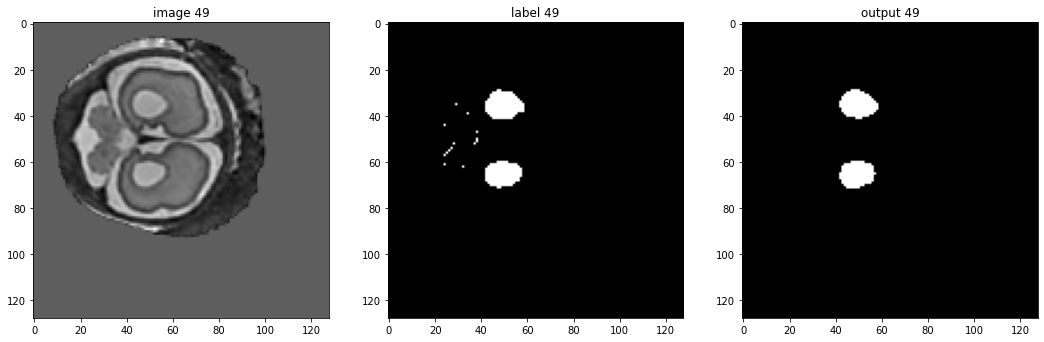

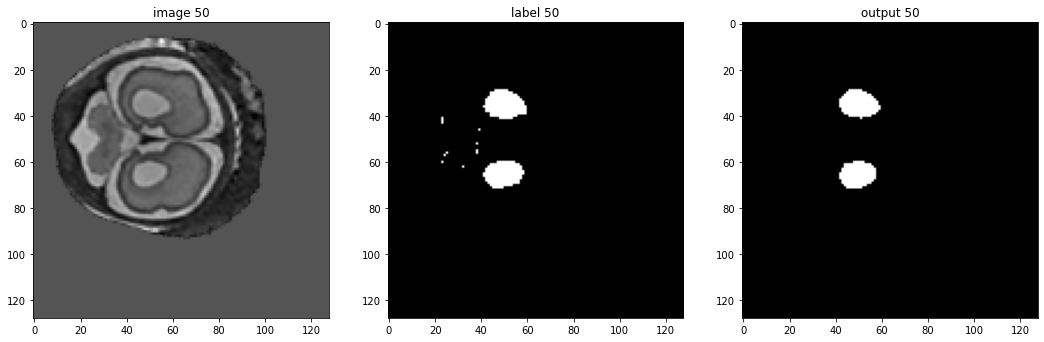

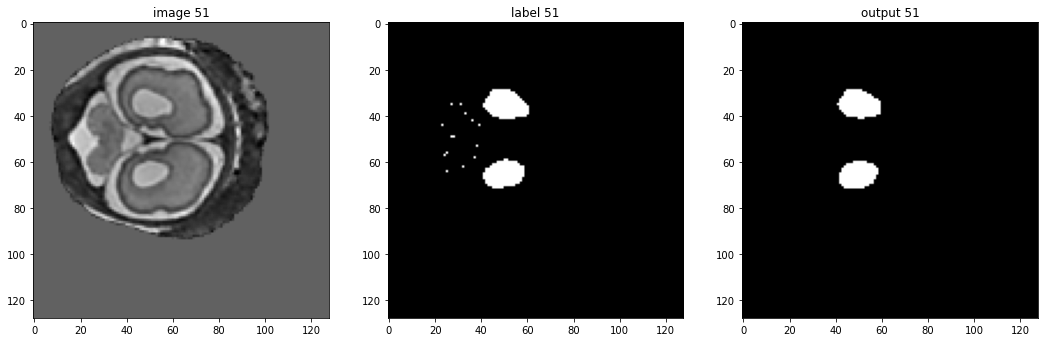

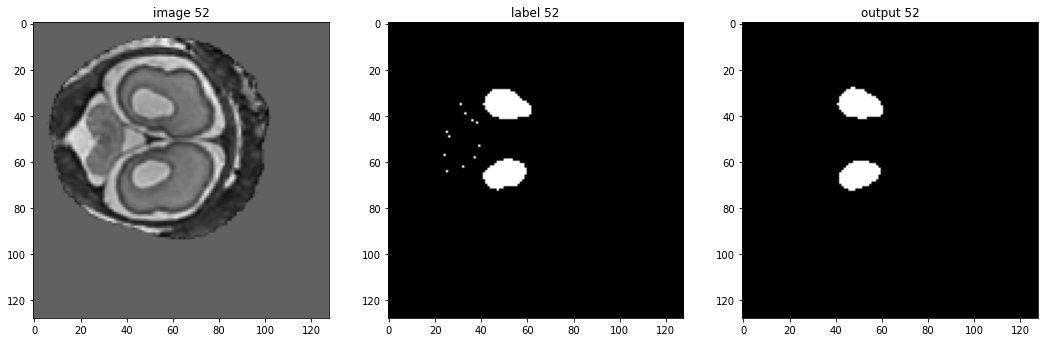

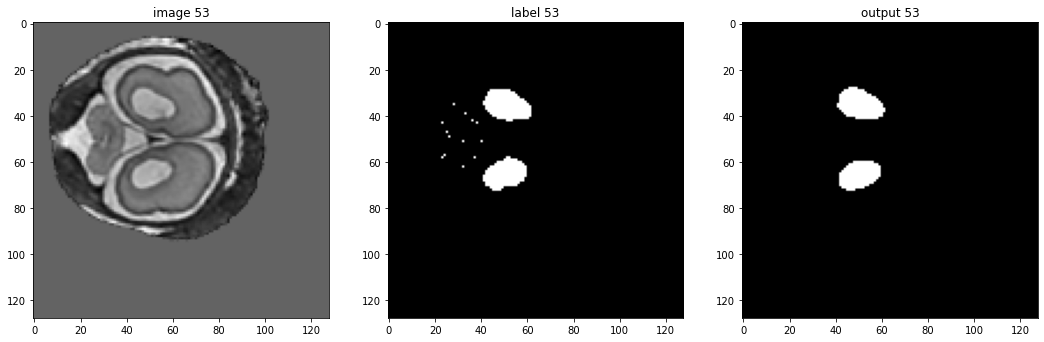

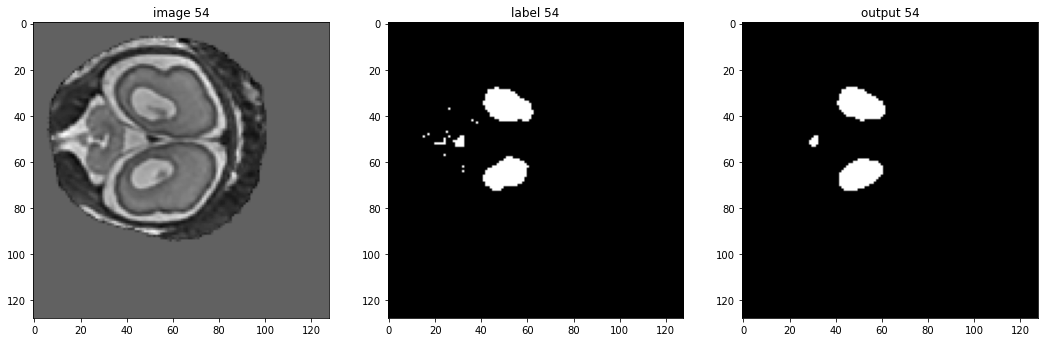

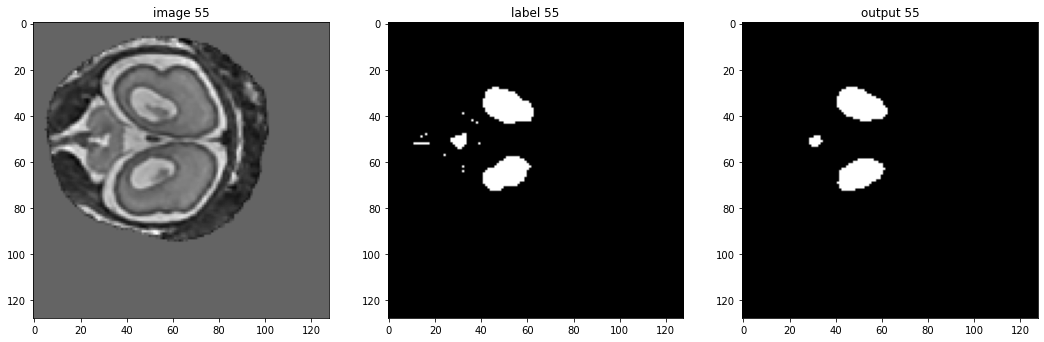

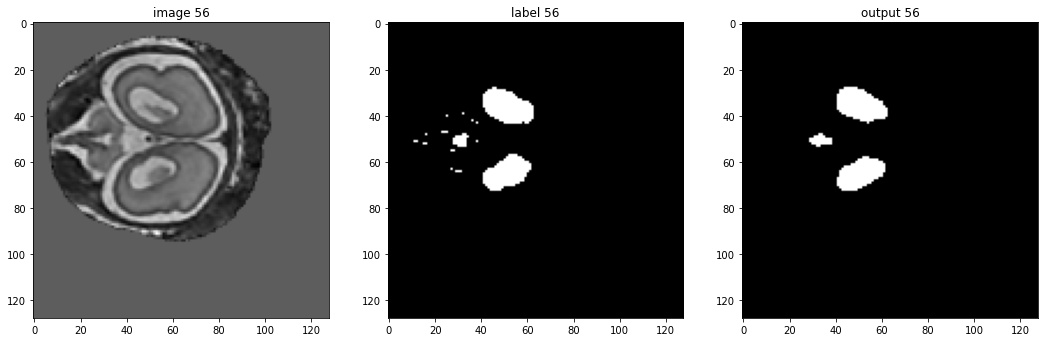

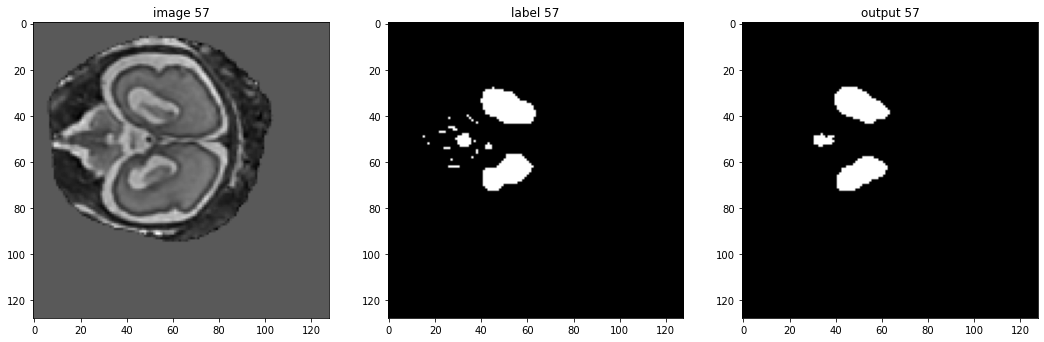

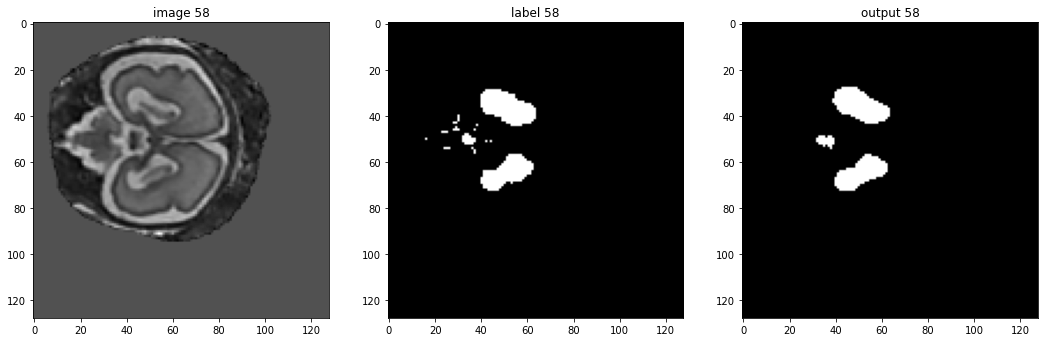

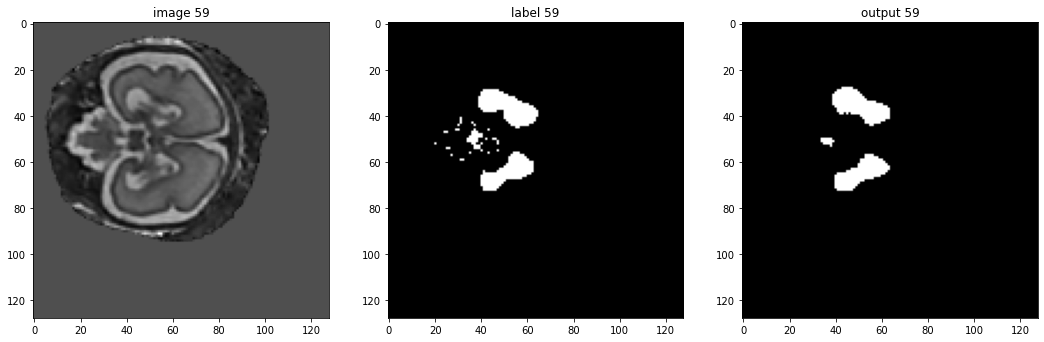

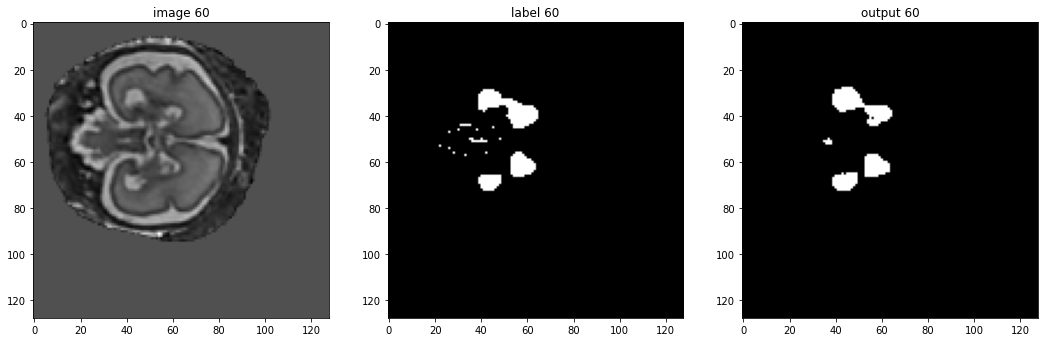

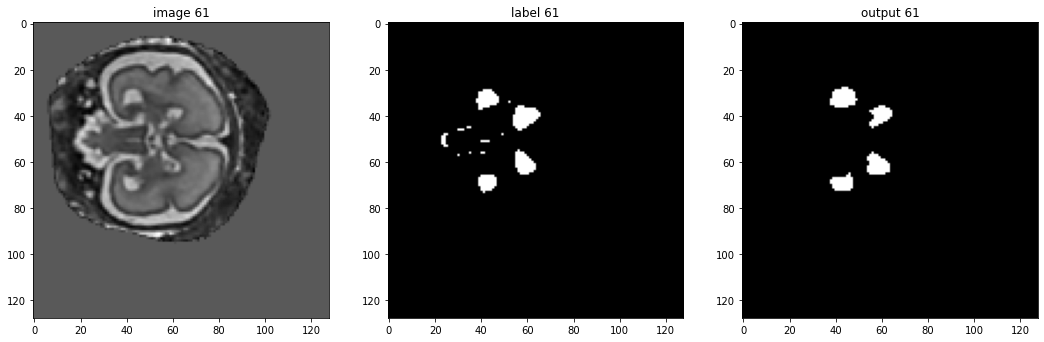

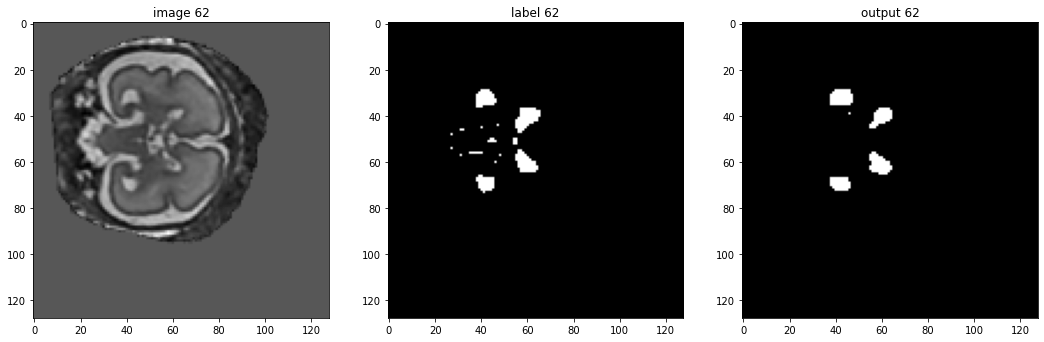

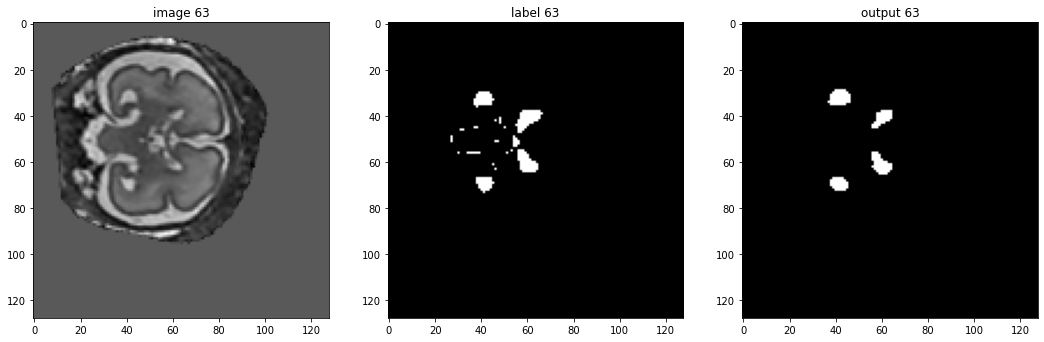

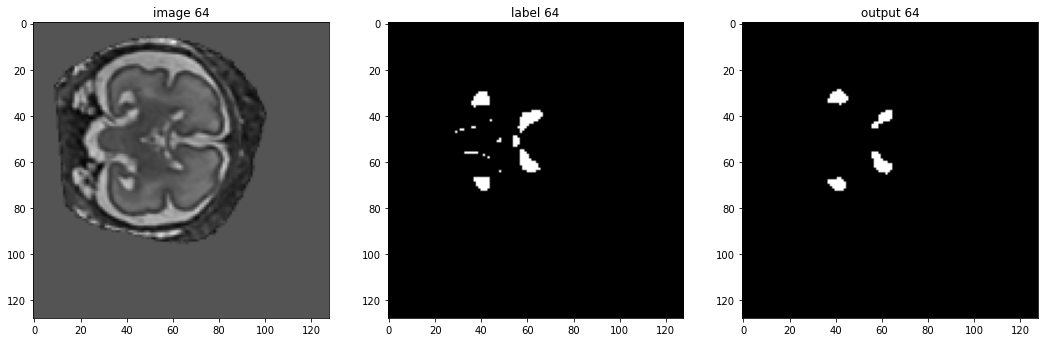

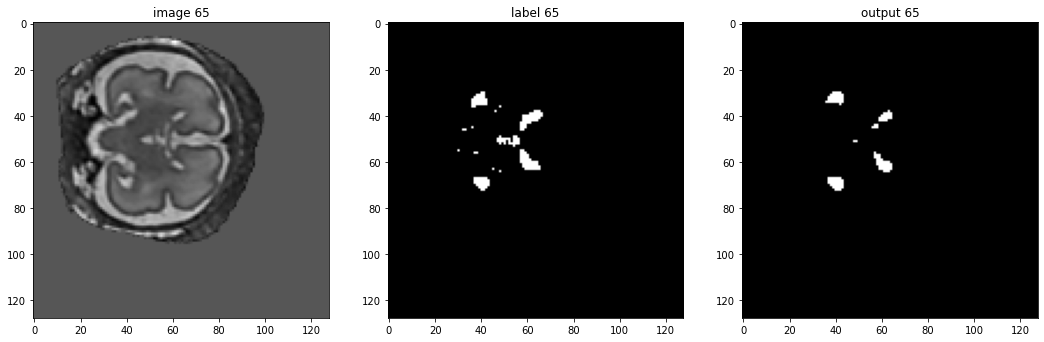

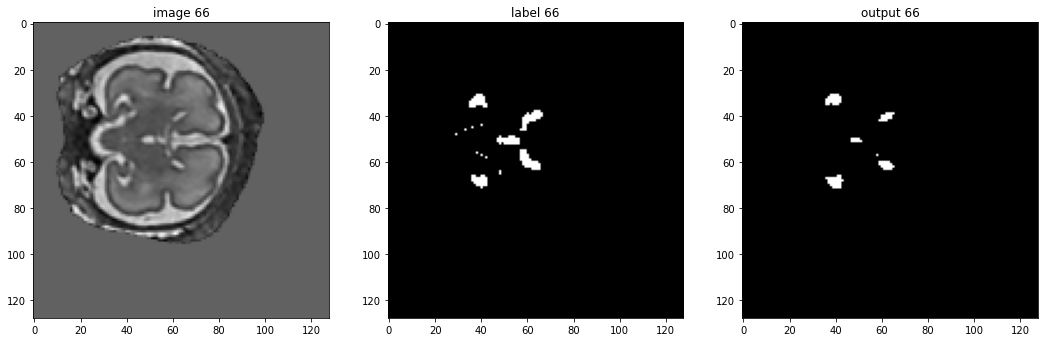

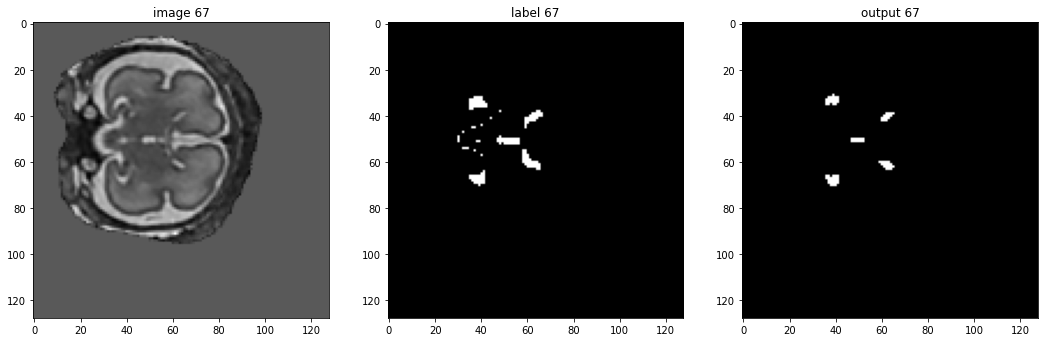

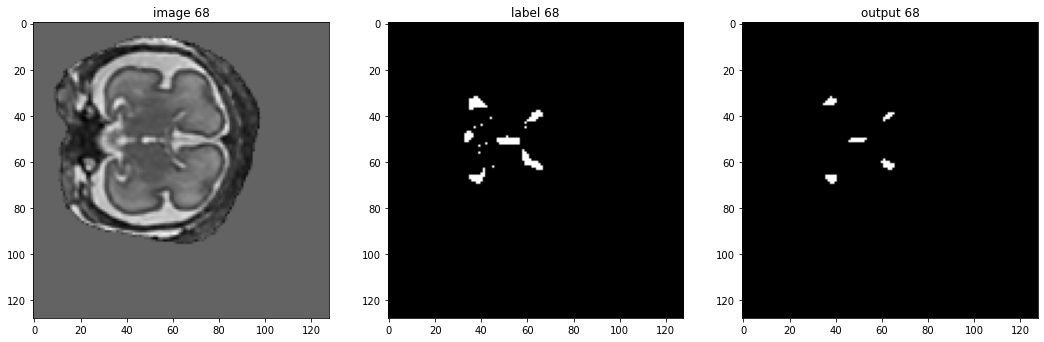

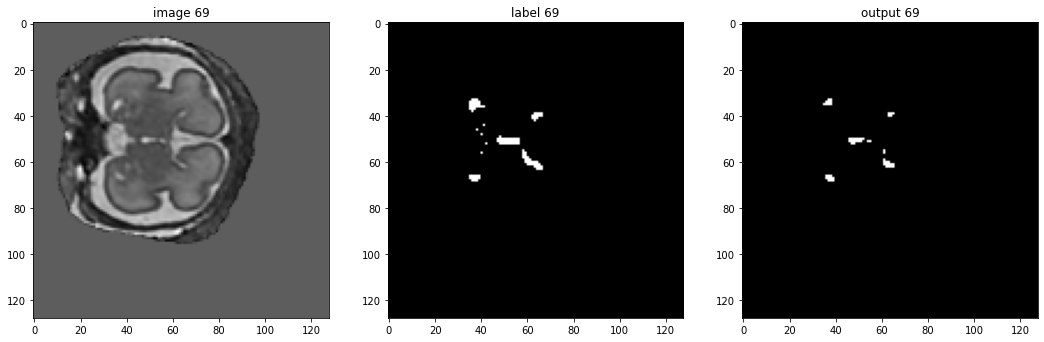

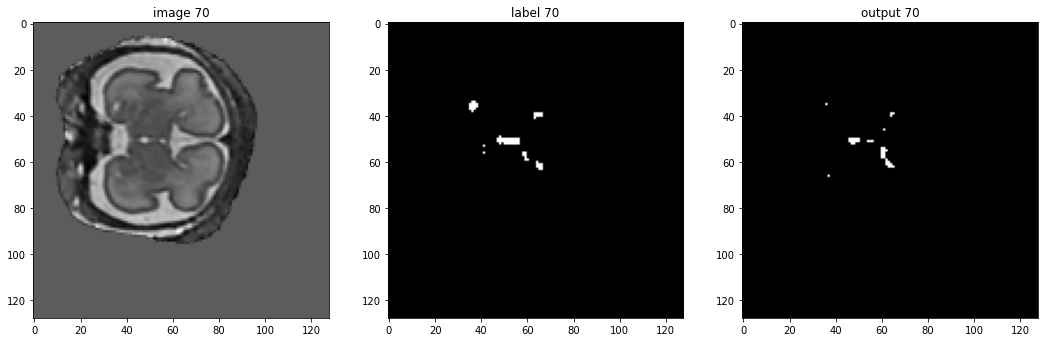

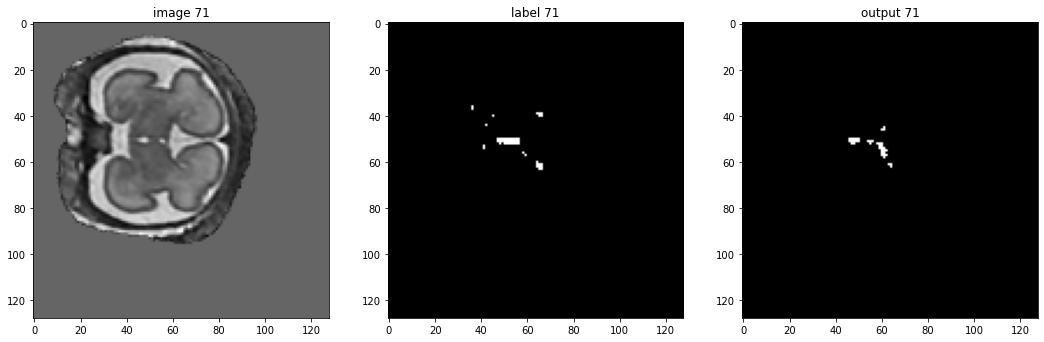

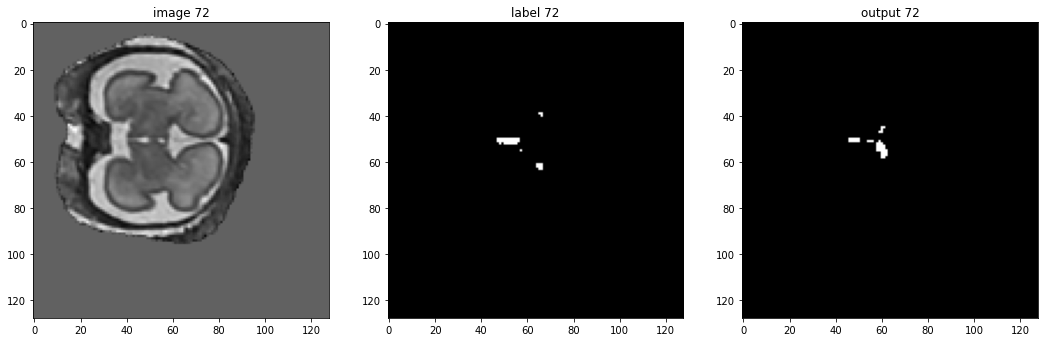

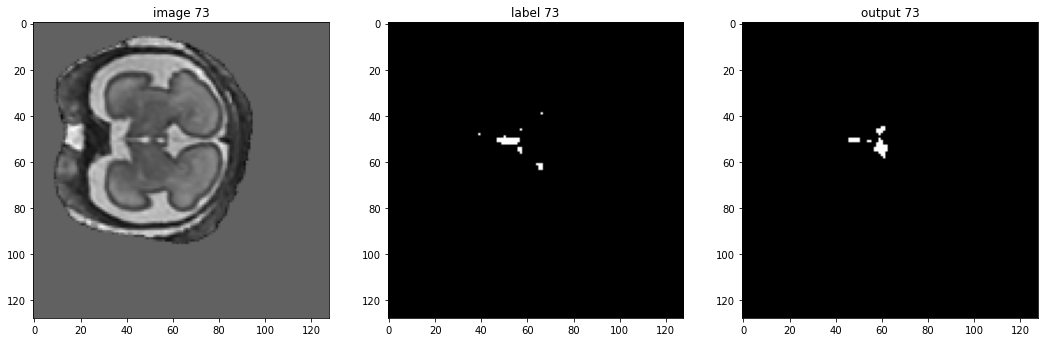

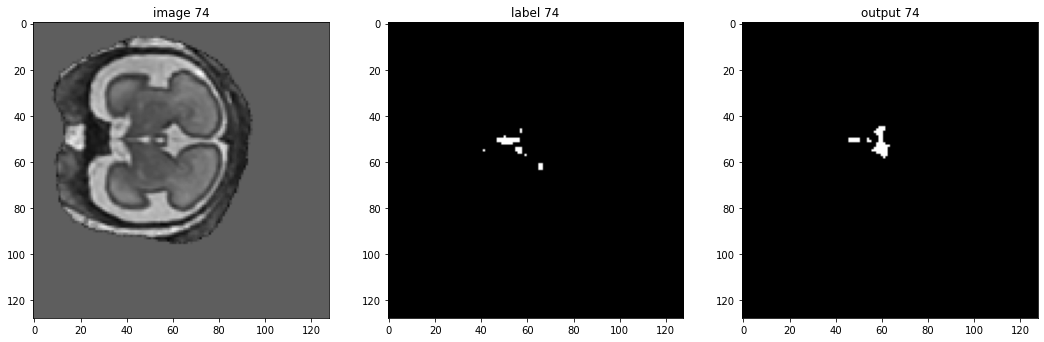

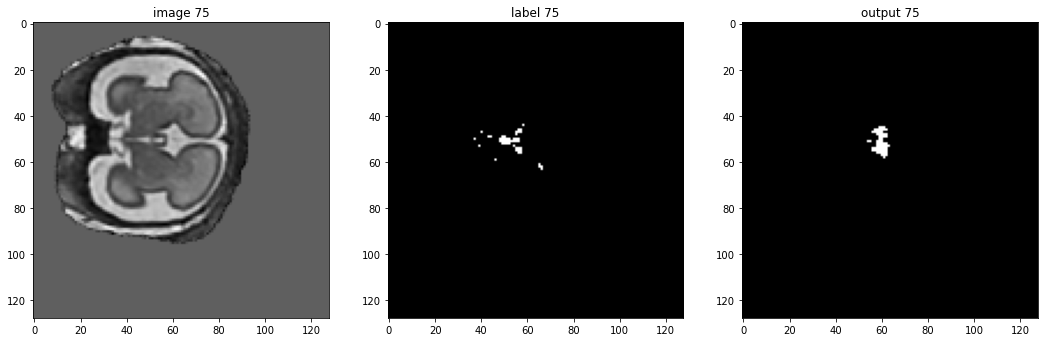

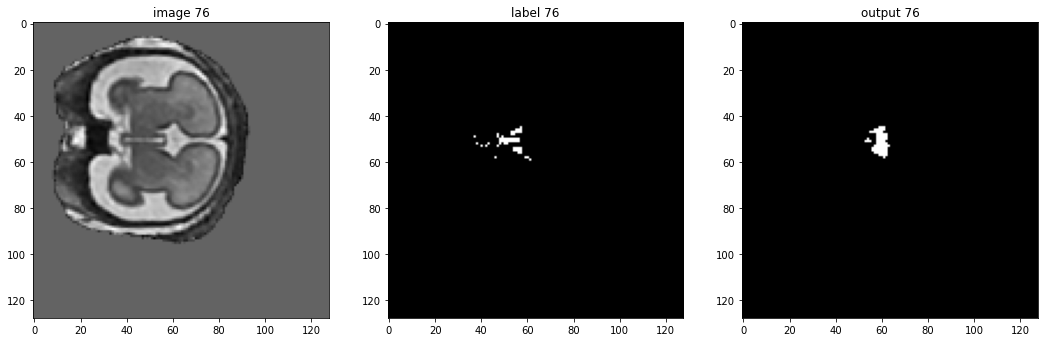

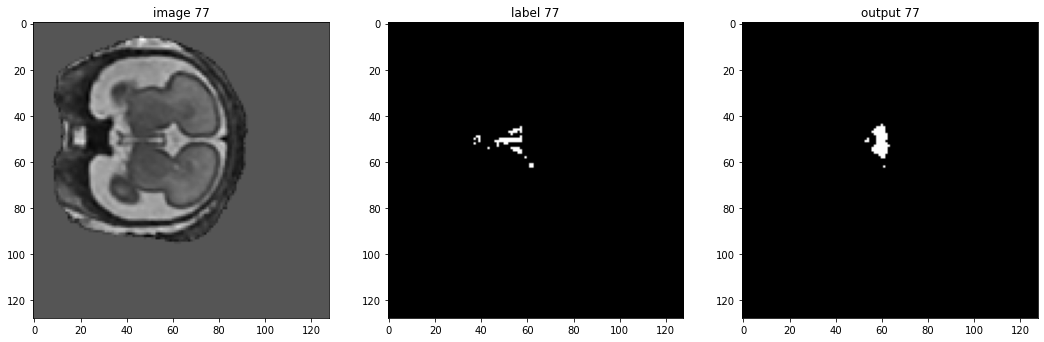

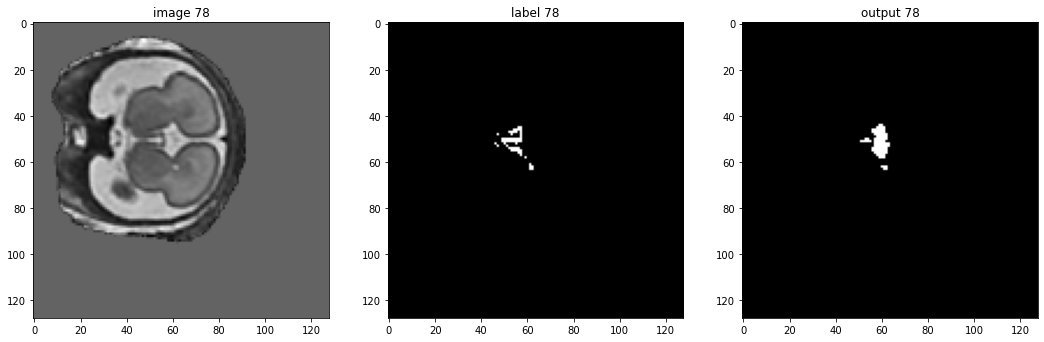

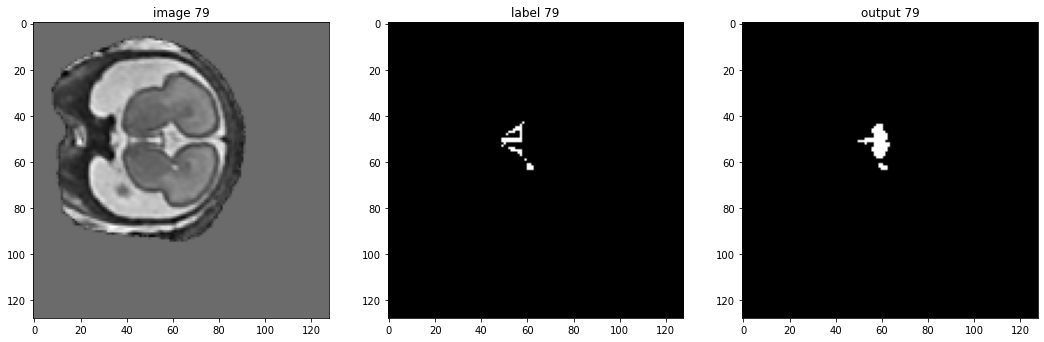

In [21]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    test_patient = test_list[2]
    t_volume = test_patient['vol']
    t_segmentation = test_patient['seg']
    
    
    test_outputs = model(t_volume.to(device))
    test_outputs = test_outputs > 0.53
        
    for i in range(40, 80):
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(t_volume[0, 0, :, i, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(t_segmentation[0, 0, :, i, :] == 4, cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, i, :], cmap="gray") # [0, 1, SAG, COR, AX]
        plt.show()